1. Load package

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly as ply
import plotly.graph_objs as go
import plotly.figure_factory as ff
from sklearn.model_selection import cross_val_score

import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression
import math
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%matplotlib inline

2. Load data

In [2]:
pd.set_option('display.max_columns', 100)

fraud_train = pd.read_csv('fraudTrain.csv')
fraud_test = pd.read_csv('fraudTest.csv')


Match data set columns

In [3]:
def match_dataframe_columns(df_train, df_test):
    try:
        return (all(df_train.columns == df_test.columns))
    except:
        return (False)


print(match_dataframe_columns(fraud_train, fraud_test))

True


In [4]:
#Merge two data sets
master_data = pd.concat([fraud_train, fraud_test], ignore_index=False)

print(master_data.describe())
print(master_data.info())

         Unnamed: 0        cc_num           amt           zip           lat  \
count  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06   
mean   5.371934e+05  4.173860e+17  7.006357e+01  4.881326e+04  3.853931e+01   
std    3.669110e+05  1.309115e+18  1.592540e+02  2.688185e+04  5.071470e+00   
min    0.000000e+00  6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01   
25%    2.315490e+05  1.800429e+14  9.640000e+00  2.623700e+04  3.466890e+01   
50%    4.630980e+05  3.521417e+15  4.745000e+01  4.817400e+04  3.935430e+01   
75%    8.335758e+05  4.642255e+15  8.310000e+01  7.204200e+04  4.194040e+01   
max    1.296674e+06  4.992346e+18  2.894890e+04  9.992100e+04  6.669330e+01   

               long      city_pop     unix_time     merch_lat    merch_long  \
count  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06   
mean  -9.022783e+01  8.864367e+04  1.358674e+09  3.853898e+01 -9.022794e+01   
std    1.374789e+01  3.014876e+05  1.819508e+07  5.

2. Data Cleaning and normalization

In [5]:
# a. Check missing value
print(master_data.isnull().sum())

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [6]:
# b. Split datetime

master_data['Dates'] = pd.to_datetime(master_data['trans_date_trans_time']).dt.date
master_data['Time'] = pd.to_datetime(master_data['trans_date_trans_time']).dt.hour


In [7]:
# Let's check data unbalance with respect with target value

temp = master_data["is_fraud"].value_counts()
df = pd.DataFrame({'is_fraud': temp.index, 'values': temp.values})

trace = go.Bar(
    x = df['is_fraud'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'is_fraud', showticklabels=True),
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class.html')

In [8]:
print(master_data.head())

   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street            city state    zip  \
0    Banks      F                561 Perry Cove  Moravian Falls    NC  28654   
1     Gill      F  43039 Riley Greens Suite 39

3. Data exploration:

In [9]:
class_0 = master_data.loc[master_data['is_fraud'] == 0]["Time"]
class_1 = master_data.loc[master_data['is_fraud'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only.html')

In [10]:
# describe dataframe
master_data['Hour'] = master_data['Time']

tmp = master_data.groupby(['Hour', 'is_fraud'])['amt'].aggregate(
    ['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'is_fraud', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

Hour  is_fraud   Min      Max  Transactions         Sum        Mean  \
0     0         0  1.00  7747.73         59832  4480332.16   74.881872   
1     0         1  6.02  1257.80           823   283487.13  344.455808   
2     1         0  1.00  4169.50         60503  4572455.30   75.574026   
3     1         1  5.60  1289.89           827   296355.77  358.350387   
4     2         0  1.00  3288.68         60003  4567315.68   76.118122   

   Median           Var  
0   61.10   9509.178116  
1  300.37  95269.999868  
2   61.44   9303.488701  
3  308.52  96454.669116  
4   62.06   9047.736679

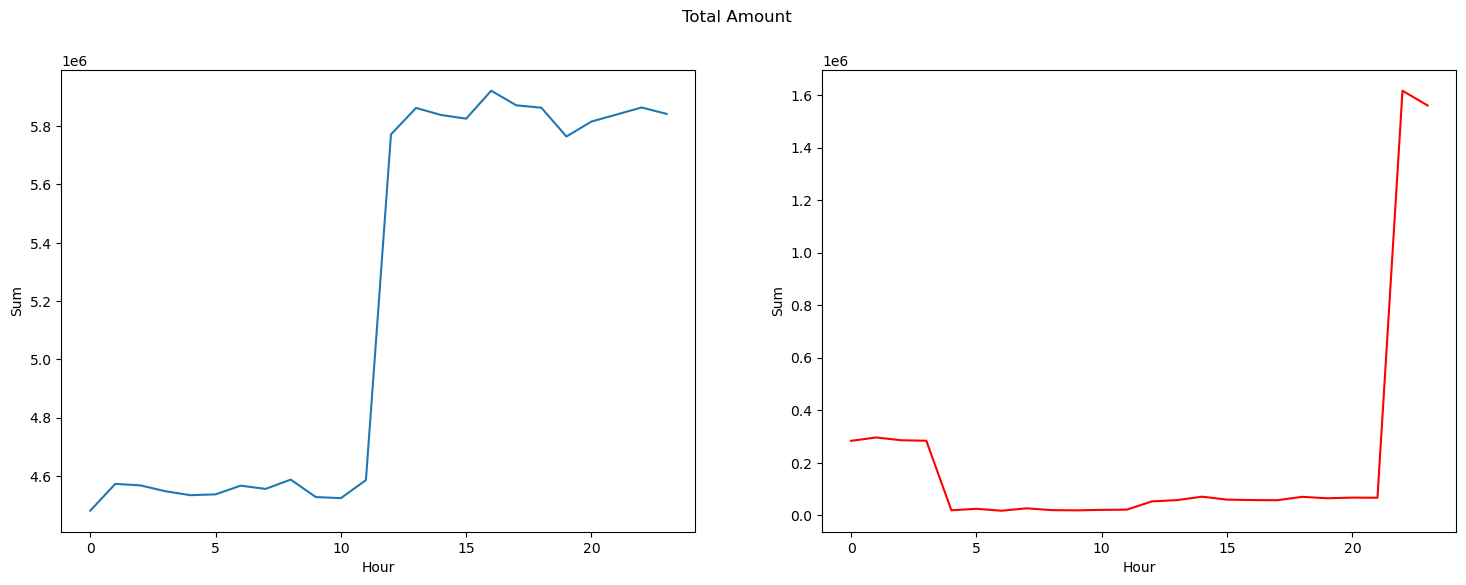

In [11]:
#Total amount of transacrions by hour, ,split by fraud 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
s = sns.lineplot(ax=ax1, x="Hour", y="Sum", data=df.loc[df.is_fraud == 0])
s = sns.lineplot(ax=ax2, x="Hour", y="Sum", data=df.loc[df.is_fraud == 1], color="red")
plt.suptitle("Total Amount")
plt.show();

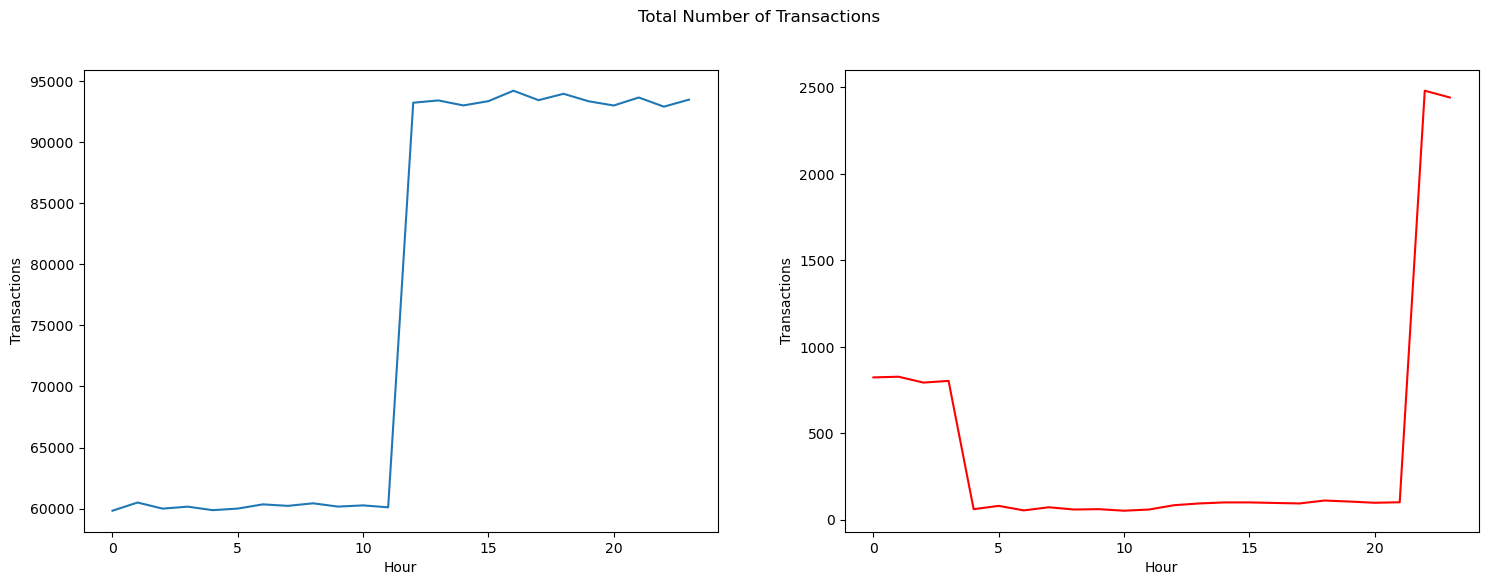

In [12]:
#Total number of transacrions by hour, ,split by fraud 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.is_fraud==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.is_fraud==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

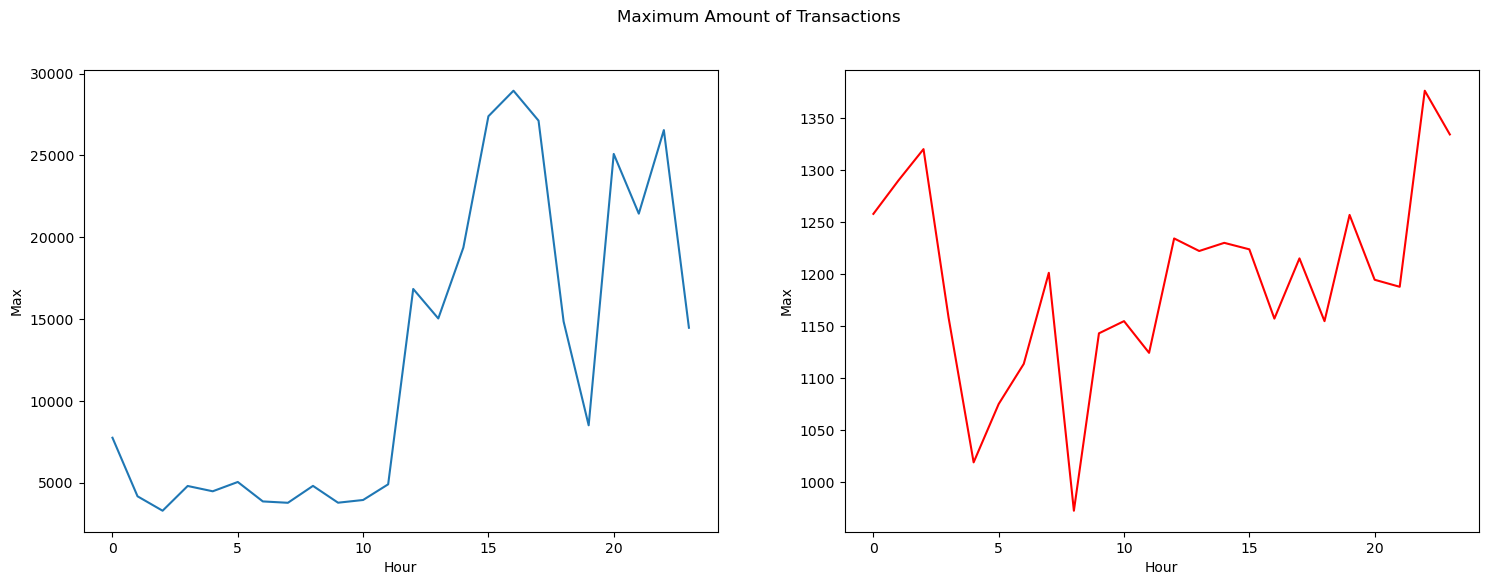

In [13]:
#Max amount of transacrions by hour, ,split by fraud 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.is_fraud==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.is_fraud==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

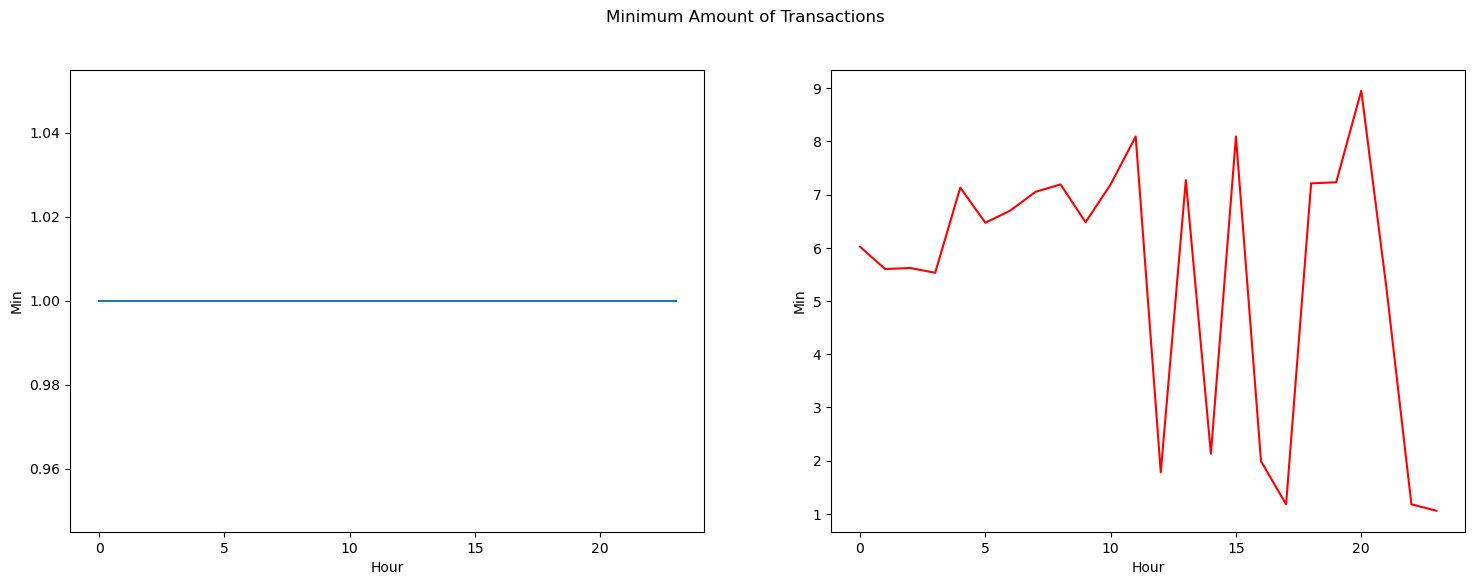

In [14]:
#Min amount of transacrions by hour, ,split by fraud 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.is_fraud==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.is_fraud==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

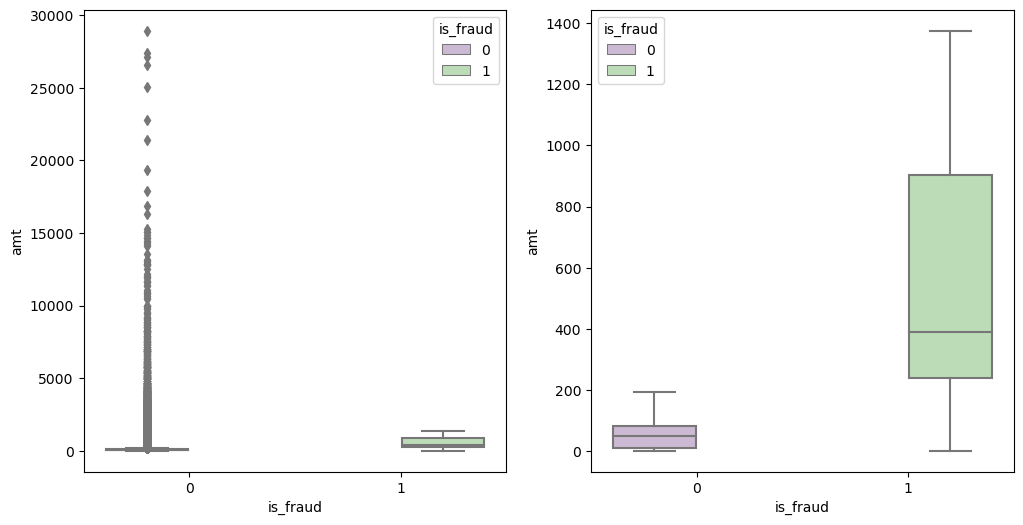

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="is_fraud", y="amt", hue="is_fraud",data=master_data, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="is_fraud", y="amt", hue="is_fraud",data=master_data, palette="PRGn",showfliers=False)
plt.show();

In [16]:
# Amount of fraudulent transactions:
fraud = master_data.loc[master_data['is_fraud'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['amt'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['amt'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [h]', showticklabels=True),
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount.html')

4. Predictive model

a. Logistic regression

In [17]:
# taking only the first 100,000 data points to make it easier to do computations on
data = master_data
data = data.sample(frac=1, random_state=1).reset_index()
data = data.head(n=100000)
data.is_fraud.value_counts()

0    99482
1      518
Name: is_fraud, dtype: int64

In [18]:
# calculating distance between credit card holder location and location of merchant

data['distance'] = np.sqrt((data['lat'] - data['merch_lat'])**2 + (data['long'] - data['merch_long'])**2)

In [19]:
# function to calculate last 30 day spending
def sum_30_day(unixtime, cc_num):
    unixstamp = unixtime
    minus30 = unixstamp - 2592000 #259200 seconds in 30 days
    ccnum = cc_num
    sumtable = data.loc[(data["cc_num"] == ccnum) & (data['unix_time'] < unixstamp) & (data['unix_time'] > minus30)]
    history30 = sumtable['amt'].sum()
    return history30


# running function and creating a new variable for it
data['history_30'] = data.apply(lambda x: sum_30_day(x.unix_time, x.cc_num), axis=1)

# measuring interaction effect with amt in new variable
data['interaction_30'] = data['history_30'] / data['amt']

In [20]:
# function to calculate last 7 day spending
def sum_7_day(unixtime, cc_num):
    unixstamp = unixtime
    minus7 = unixstamp - 604800 #second in 7 days
    ccnum = cc_num
    sumtable = data.loc[(data["cc_num"] == ccnum) & (data['unix_time'] < unixstamp) & (data['unix_time'] > minus7)]
    history7 = sumtable['amt'].sum()
    return history7


# running function and creating a new variable for it
data['history_7'] = data.apply(lambda x: sum_7_day(x.unix_time, x.cc_num), axis=1)

# measuring interaction effect with amt in new variable
data['interaction_7'] = data['history_7'] / data['amt']

In [21]:
# Create data set for linear regression; dropping non categorical variables in preperation for regression modeling; cleaning unecessary and create new measures
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  100000 non-null  int64  
 1   Unnamed: 0             100000 non-null  int64  
 2   trans_date_trans_time  100000 non-null  object 
 3   cc_num                 100000 non-null  int64  
 4   merchant               100000 non-null  object 
 5   category               100000 non-null  object 
 6   amt                    100000 non-null  float64
 7   first                  100000 non-null  object 
 8   last                   100000 non-null  object 
 9   gender                 100000 non-null  object 
 10  street                 100000 non-null  object 
 11  city                   100000 non-null  object 
 12  state                  100000 non-null  object 
 13  zip                    100000 non-null  int64  
 14  lat                    100000 non-nul

In [22]:
# dropping non categorical variables in preperation for regression modeling; cleaning unecessary and create new measures

data = data.drop('Unnamed: 0', axis=1)
data = data.drop('trans_num', axis=1)
data = data.drop('first', axis=1)
data = data.drop('last', axis=1)
data = data.drop('street', axis=1)
data = data.drop('city', axis=1)


C:\Users\thugi\AppData\Local\Temp\ipykernel_10444\73479231.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

C:\Users\thugi\AppData\Local\Temp\ipykernel_10444\73479231.py:3: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



PlotlyError: The `figure_or_data` positional argument must be `dict`-like, `list`-like, or an instance of plotly.graph_objs.Figure

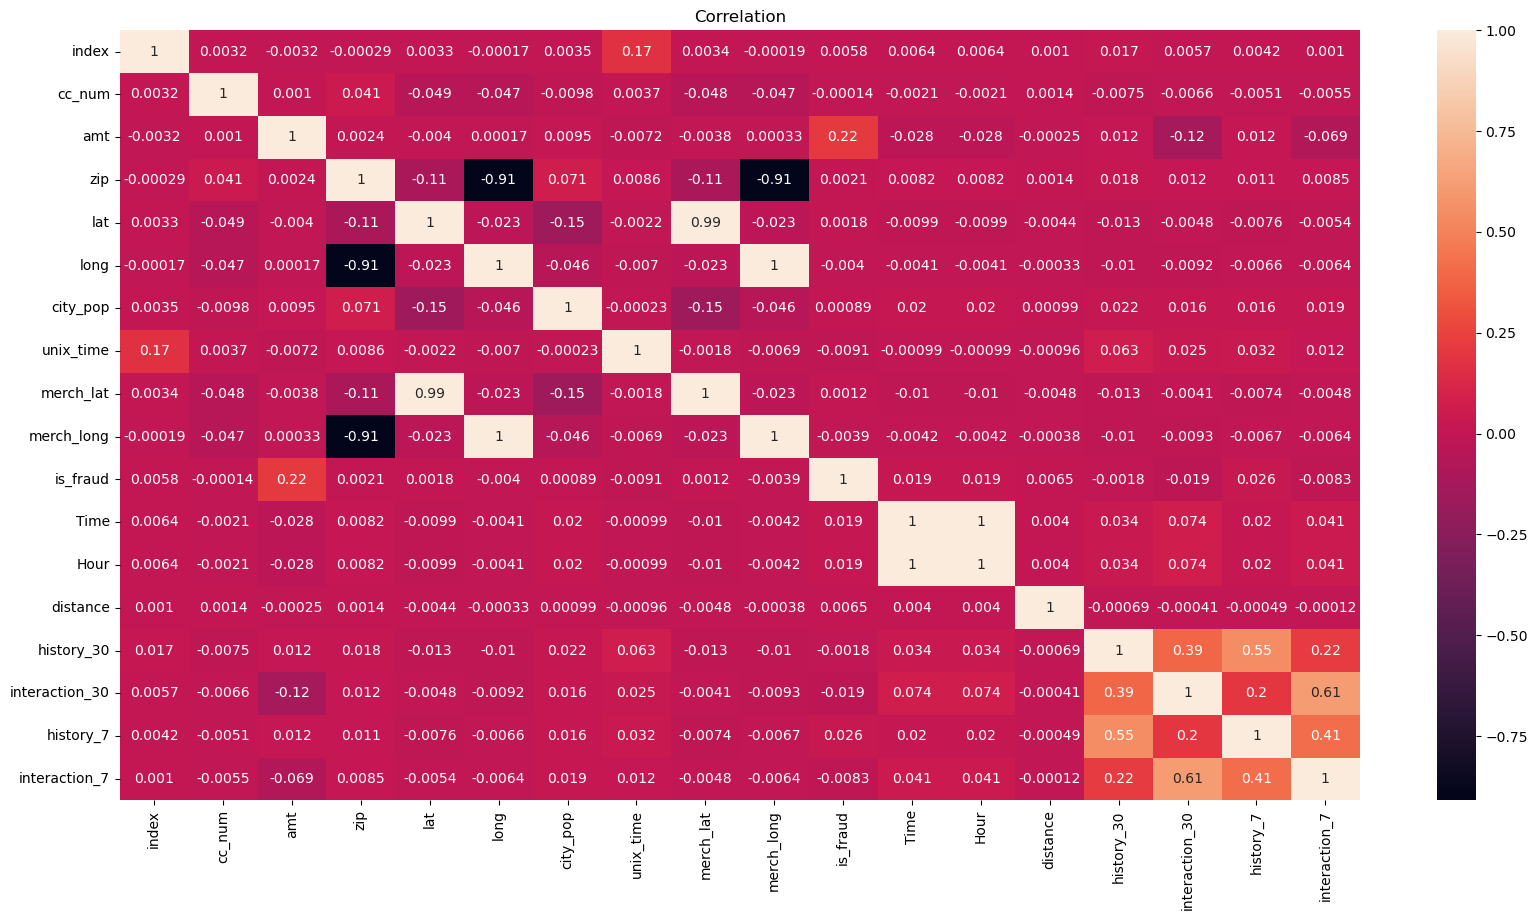

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(data.corr(),annot=True).set_title('Correlation')
fig.show()
iplot(fig, filename='heatmap1')

In [24]:
#Drop multicolineary variables and more non categorical
data = data.drop('cc_num', axis=1)
data = data.drop('zip', axis=1)
data = data.drop('lat', axis=1)
data = data.drop('long', axis=1)
data = data.drop('unix_time', axis=1)
data = data.drop('merch_lat', axis=1)
data = data.drop('merch_long', axis=1)
data = data.drop('Dates', axis=1)
data = data.drop('trans_date_trans_time', axis=1)
data = data.drop('state', axis=1)
data = data.drop('merchant', axis=1)
data = data.drop('job', axis=1)
data = data.drop('dob', axis=1)
data = data.drop('category', axis=1)
data = data.drop('gender', axis=1)
data = data.drop('Time', axis=1)
data = data.drop('index', axis=1)

C:\Users\thugi\AppData\Local\Temp\ipykernel_10444\29864922.py:3: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



PlotlyError: The `figure_or_data` positional argument must be `dict`-like, `list`-like, or an instance of plotly.graph_objs.Figure

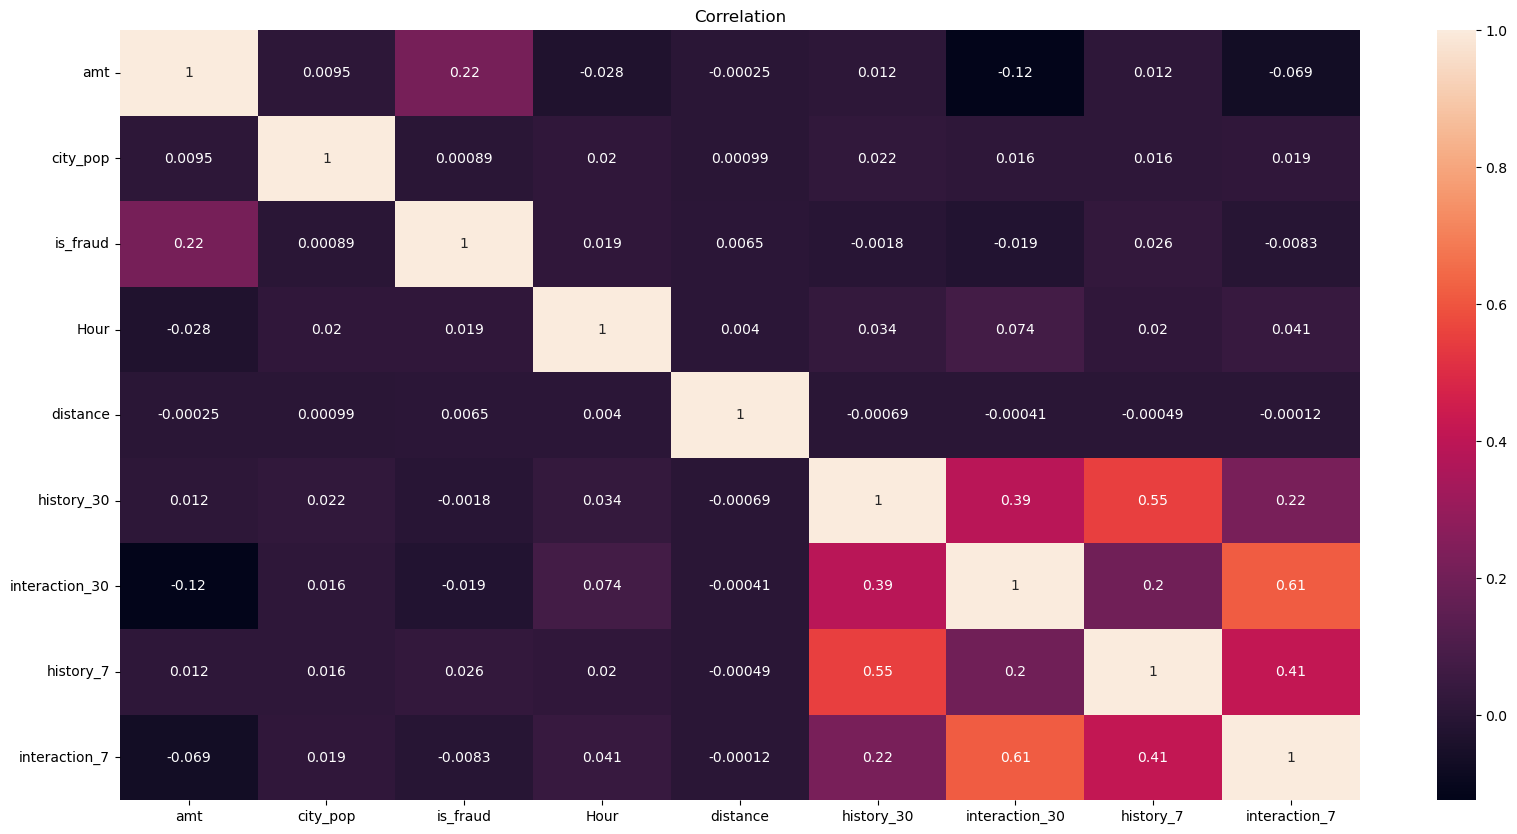

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(data.corr(),annot=True).set_title('Correlation')
fig.show()
iplot(fig, filename='heatmap2')

In [26]:
#logistic regression algorithim for binary classification. (categorical variables)

y = data['is_fraud']
x = data.drop('is_fraud', axis=1) 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred)

print(accuracy)


0.99335


C:\Users\thugi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

